In [ ]:
!pip install tensorflow==2.16.2

In [ ]:
!pip install numpy==1.23.5

In [ ]:
!pip install tf-keras==2.16

In [ ]:
import pandas as pd
import torch
import tensorflow as tf
import numpy as np
import tf_keras
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler  # to adjust learning rate dynamically during training
from sklearn.metrics import accuracy_score
from torch import nn

In [ ]:
# Check versions
print(torch.__version__)
print(tf.__version__)
print(tf_keras.__version__)
print(np.__version__)

2.5.1+cu124
2.16.2
2.16.0
1.23.5


# Base Model

## Load the dataset

In [ ]:
file_path = "https://raw.githubusercontent.com/yamphurai/Fairness_and_Ethical_considerations/refs/heads/main/amazon_reviews.csv"

In [ ]:
# Read the dataset
dataset = pd.read_csv(file_path)

In [ ]:
dataset.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [ ]:
# Basic statistics
dataset.describe(include="all")

,sentiments,cleaned_review,cleaned_review_length,review_score
count,17340,17321,17340.000000,17340.000000
unique,3,13100,NaN,NaN
top,positive,love it,NaN,NaN
freq,9503,71,NaN,NaN
mean,NaN,NaN,30.300461,3.649077
std,NaN,NaN,35.836540,1.673500
min,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,9.000000,2.000000
50%,NaN,NaN,20.000000,5.000000
75%,NaN,NaN,38.000000,5.000000


In [ ]:
dataset["sentiments"].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

There are three sentiments (labels) assigned.

In [ ]:
# Checking for null values in each column
print(dataset["sentiments"].isna().sum())
print(dataset["cleaned_review"].isna().sum())
print(dataset["cleaned_review_length"].isna().sum())
print(dataset["review_score"].isna().sum())

0
19
0
0


In [ ]:
# let's evaluate the rows with null values
print(dataset[dataset["cleaned_review"].isna()])

      sentiments cleaned_review  cleaned_review_length  review_score
2085     neutral            NaN                      0           5.0
2894     neutral            NaN                      0           5.0
4333     neutral            NaN                      0           5.0
6043     neutral            NaN                      0           5.0
6841     neutral            NaN                      0           4.0
9526     neutral            NaN                      0           4.0
10063    neutral            NaN                      0           3.0
11388    neutral            NaN                      0           5.0
12912    neutral            NaN                      0           4.0
14435    neutral            NaN                      0           5.0
15481    neutral            NaN                      0           5.0
15557    neutral            NaN                      0           5.0
16222    neutral            NaN                      0           4.0
16495    neutral            NaN   

There are only 19 null values which is only 0.1% of the total reviews. Also, we can't replace them with any other statistical values since these are to be filled with reviews which is not possible. So we will remove them.

In [ ]:
dataset = dataset.dropna(subset=["cleaned_review"])

In [ ]:
# Basic statistics
dataset.describe(include="all")

,sentiments,cleaned_review,cleaned_review_length,review_score
count,17321,17321,17321.000000,17321.000000
unique,3,13100,NaN,NaN
top,positive,love it,NaN,NaN
freq,9503,71,NaN,NaN
mean,NaN,NaN,30.333699,3.647942
std,NaN,NaN,35.842128,1.673961
min,NaN,NaN,1.000000,1.000000
25%,NaN,NaN,9.000000,2.000000
50%,NaN,NaN,20.000000,5.000000
75%,NaN,NaN,38.000000,5.000000


No null values left in the dataset. We ended having 17,321 samples in our dataset.

In [ ]:
dataset_final = dataset[["sentiments", "cleaned_review"]]

In [ ]:
# final dataset
dataset_final.head()

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...


## Load BERT model and tokenizer

We will load the pretrained BERT uncased model. We want to perform classification, so we will need to get BertForSequenceClassifiction as it includes a fully connected classification layer on top of the BERT model

In [ ]:
# Load the BERT model
model_base = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3,
                                                      output_hidden_states=False
                                                     )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Let's evaluate the base model architecture
model_base

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Base model architecture:**
- We have BERT model that contains embeddings, word_embeddings, position_embeddings, token_type_embeddings, LayerNorm, and dropout
- It then goes into BertEncoder that is simply 12 identical layers where we have self attention layer, query, key, value, and dropout
- Then it goes through couple of dense layers: output "BertSelfOutput, intermediate "BertIntermediate", and output "BertOutput
- Then it goes through a pooling layer "BertPooler" that has output of 768 (linear)
- Finally it goes through a classifier layer (untrained) that expects intput of 768 and will have output of 20 (number of layers for classification)

In [ ]:
# place the based model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_base.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Preprocess the final dataset

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm, trange

In [ ]:
# Let's look at the max length tokens of the review in the dataset

# Tokenizing each sample and counting the number of tokens
token_counts = dataset["cleaned_review"].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

# Find the maximum token count in the dataset
max_token_count = token_counts.max()
print("Maximum token count in the dataset:", max_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Maximum token count in the dataset: 598


Since there are some reviews that have more than 512 tokens, we will need to truncate them to 512 tokens to be used for BERT model.

In [ ]:
max_tokens = 512

# list to store each sample as a dictionary that contains tokenized review and corresponding label
encoded_dataset = []

# to count samples processed
samples_processed = 0

# Map the text labels to integers
label_map = {"negative":0, "neutral":1, "positive":2}


# iterate through each sample in the dataset_final
for text, label in tqdm(zip(dataset_final['cleaned_review'], dataset_final['sentiments']), desc="Encoding", total=len(dataset_final['sentiments'])):

    # Tokenize the text with truncation and padding. Returned as PyTorch tensors
    encoded_example = tokenizer(text, return_tensors='pt',
                                truncation=True,
                                padding='max_length',
                                max_length=max_tokens)

    # Convert the string labels to integer labels as mapped above
    encoded_example['label_id'] = label_map.get(label)

    # Check if the tokenized sequence length is correct
    assert len(encoded_example.input_ids[0]) == max_tokens

    # Add the encoded example to the dataset_final
    encoded_dataset.append(encoded_example)

Encoding:   0%|          | 0/17321 [00:00<?, ?it/s]

In [ ]:
# Let's evaluate sample at index 1 to see the encoded sample
encoded_dataset[1]

{'input_ids': tensor([[  101,  1045,  2310,  4342,  2023, 10800,  2153,  2330,  1996,  7427,
          1998,  2224,  1996,  4031,  2157,  2185,  3641,  2023,  8000,  1999,
          2257,  2004,  2026,  3604,  8000,  1998,  2074,  8966,  2009,  2185,
          1999,  2026,  4524,  2085,  2310,  2042,  5873,  2155,  1999,  1996,
          1052,  2078,  2860,  2144,  3054,  2244,  1996,  8000,  2165,  3715,
          1998,  2499,  2986,  2005,  3232,  1997,  3134,  2044, 28667,  8167,
          5999,  1996,  8000,  2009,  2499,  2005,  2154,  2030,  2048,  1998,
          2059,  7024,  2000,  3853,  1996,  9380,  2422,  2097,  5956,  2320,
          2043,  2357,  2006,  2059,  2498,  1997,  2607,  1996,  2709,  3332,
          2003,  2092,  2627,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

We can see the encoded dictionary with keys input_ids, token_type_ids, attention_maks, and label_id with their tensors as their values. All of them have been padded to 512 tokens.

## Training and Evaluation datasets

Create a tensor dataset from our dataset_final that takes all of the tensors from input text and labels, and combine them into a single dataset object. This ensures that all the required inputs for our BERT model are packaged together and we can do batch processing.

In [ ]:
Batch_size = 16
total_reviews = 17321   #total number of reviews
train_size = int(0.8*total_reviews)   #set 80% as training data
eval_size = total_reviews - train_size   #set 20% as evaluation data


# Create the TensorDataset by extracting values from the existing dataset
input_ids = torch.stack([sample['input_ids'].squeeze(0) for sample in encoded_dataset], dim=0)
attention_mask = torch.stack([sample['attention_mask'].squeeze(0) for sample in encoded_dataset], dim=0)
token_type_ids = torch.stack([sample['token_type_ids'] for sample in encoded_dataset], dim=0)
label_ids = torch.tensor([sample['label_id'] for sample in encoded_dataset], dtype=torch.long)

# Create the TensorDataset
all_data_tensors = TensorDataset(input_ids, attention_mask, token_type_ids, label_ids)

# randomly split that dataset into trainig and evaluation datasets
train_data, eval_data = random_split(all_data_tensors, [train_size, eval_size])

# take random samples from the training data as training samples)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=Batch_size)  #load the samples in batches

# do the same for the evaluation dataset (no need to random pick)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=Batch_size)

print(f"Created two datasets training/eval. Training samples: {train_size}, Evaluation: {eval_size}")

# free up some memory, already saved in the new dataset "all_data_tensors"
del encoded_dataset

Created two datasets training/eval. Training samples: 13856, Evaluation: 3465


When we tokenized the texts and computed tensors, there will be one extra batch dimension in the input_ids, attention_mask. The BertForSequenceClassification expects only 2D tensor for these parameters i.e. [batch_size, seq_length]. So we performed "squeeze" above. So let's check their shapes before proceeding.

In [ ]:
print(input_ids.shape)  # Should be [16, 512]
print(attention_mask.shape)  # Should be [16, 512]
print(label_ids.shape)  # Should be [16]

torch.Size([17321, 512])
torch.Size([17321, 512])
torch.Size([17321])


Since we have performed batch processing yet, there are 17321 samples in the dataset, and they all have 512 tensors. We are good to proceed.

In [ ]:
# Iterate over the train_dataloader and print the first batch
for batch in train_dataloader:
  input_ids, attention_mask, token_type_ids, labels = batch  # Unpack the batch
  print(input_ids)
  print(attention_mask)
  print(token_type_ids)
  print(labels)
  break  # Only print the first batch, remove break to print all batches

tensor([[  101,  2023,  3131,  ...,     0,     0,     0],
        [  101, 24970, 15781,  ...,     0,     0,     0],
        [  101,  2005, 13751,  ...,     0,     0,     0],
        ...,
        [  101,  3866,  2673,  ...,     0,     0,     0],
        [  101,  1045,  2123,  ...,     0,     0,     0],
        [  101,  2307,  9233,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])
tensor([2, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 2])


Checking the first batch from the training dataset, we can see that we have all the tensors as values for corresponding keys in the dictionary. There are 16 samples in the batch.

In [ ]:
# Iterate over the eva_dataloader and print the first batch
for batch in eval_dataloader:
  input_ids, attention_mask, token_type_ids, labels = batch  # Unpack the batch
  print(input_ids)
  print(attention_mask)
  print(token_type_ids)
  print(labels)
  break  # Only print the first batch, remove break to print all batches

tensor([[ 101, 4952, 2000,  ...,    0,    0,    0],
        [ 101, 2009, 2134,  ...,    0,    0,    0],
        [ 101, 1045, 2941,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2293,  ...,    0,    0,    0],
        [ 101, 2057, 4198,  ...,    0,    0,    0],
        [ 101, 1045, 2288,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])
tensor([2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 2])


Same as above for evaluation dataset

## Train base BERT model

Now we will setup tracking for training and validation loss. We will freeze all the layers of BERT first. Unfreeze the last pooling layer of BERT and its classifier layer. Then we will add them to be passed to the optimzer before being trained.

In [ ]:
# setup tracking.
history_base = {}  # empty dict to store training history of the base model
history_base['val_loss'] = []  # stores validation loss values
history_base['train_loss'] = []  # stores training loss values

epochs = 3

# Go thru all parameters of the model and freeze entire model initially.
for param in model_base.parameters():
    param.requires_grad = False

# only train the parameters for pooler layer of BERT (final layer before our classifier layer)
for param in model_base.bert.pooler.parameters():
    param.requires_grad = True

# only train the classifier layer that we added to BERT model
for param in model_base.classifier.parameters():
    param.requires_grad = True

# now add the lists of the parameters from pooler layer and classifier layer to pass them through optimizer
train_params = list(model_base.bert.pooler.parameters()) + list(model_base.classifier.parameters())

# we can now tell the optimizer to only optimize these parameters in the model
optimizer = Adam(train_params)

Next, we will train our model for certain number of epochs. While training, we will track the training loss. After each epoch, we will evaluation the model's performance on the validation set.
This validation loss will also be tracked. For visual purpose, we will use progress bars to show current epoch, training progress, and evaluation progress.
Finally, we will save the loss values for training and validation for future analysis.

In [ ]:
# setting up a progress bar for epochs
with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_base.train()  # put the model in training mode
        total_loss = 0.0  # track the training loss

        # iterate over training data in batchs using train_dataloader.
        for batch in tqdm(train_dataloader, desc=f"Training {epoch}", total=int(train_size/Batch_size)+1, leave=False):

            # send batch (tuple of below input parameters & labels) to GPU and separate for the model
            batch = tuple(s.to(device) for s in batch)
            input_ids, input_mask, input_types, labels = batch  # unpack those parameters of the tuple

            # pass these parameters thru model to perform forward pass. This will compute model's output (includes training loss)
            output = model_base(input_ids=input_ids, attention_mask=input_mask, labels=labels)

            # back propagation
            output.loss.backward() # computes gradients by backpropagation using the loss
            optimizer.step() # use gradients in optimizer to update model's parameters
            optimizer.zero_grad() # clear out gradients of optimized tensors to avoid accumulation of gradients between different batches

            # keep track of total train loss. Need to multiply loss per sample by batch size for total loss
            total_loss += output.loss.item() * Batch_size

        # calcualte the avg. training loss and add it to the train_loss
        total_loss = total_loss / train_size
        history_base['train_loss'].append(total_loss)

        # at end of epoch, report the evaluation
        model_base.eval()  # Set model to evaluation mode (droput layers and other training specific operations are turned off)
        total_loss = 0.0  #rest the total loss to 0 to track the validation loss

        # turn of gradient calculation as we're only evaluating the model
        with torch.no_grad():

            # evaluation in batches (same as above)
            for batch in tqdm(eval_dataloader, desc=f"Evaluating {epoch}", total=int(eval_size/Batch_size)+1, leave=False):
                batch = tuple(s.to(device) for s in batch) # send to GPU
                input_ids, input_mask, input_types, labels = batch
                output = model_base(input_ids, input_types, input_mask, labels=labels)
                total_loss += output.loss.item() * Batch_size

            total_loss = total_loss / eval_size
            history_base['val_loss'].append(total_loss)

        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training 0:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating 0:   0%|          | 0/217 [00:00<?, ?it/s]

Training 1:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating 1:   0%|          | 0/217 [00:00<?, ?it/s]

Training 2:   0%|          | 0/867 [00:00<?, ?it/s]

Evaluating 2:   0%|          | 0/217 [00:00<?, ?it/s]

We are training only for 3 epochs because found that the model performance stopped improving much after third epoch.

## Save the trained model and download for future use

In [ ]:
# Save the trained model & tokenizer
model_base.save_pretrained("bert_model_base")
tokenizer.save_pretrained('/content/bert_model_base')


('/content/bert_model_base/tokenizer_config.json',
 '/content/bert_model_base/special_tokens_map.json',
 '/content/bert_model_base/vocab.txt',
 '/content/bert_model_base/added_tokens.json')

In [ ]:
!zip -r bert_model_base.zip bert_model_base

updating: bert_model_base/ (stored 0%)
updating: bert_model_base/model.safetensors (deflated 7%)
updating: bert_model_base/tokenizer_config.json (deflated 75%)
updating: bert_model_base/special_tokens_map.json (deflated 42%)
updating: bert_model_base/config.json (deflated 51%)
updating: bert_model_base/vocab.txt (deflated 53%)
  adding: bert_model_base/bert_model_base/ (stored 0%)
  adding: bert_model_base/bert_model_base/model.safetensors (deflated 7%)
  adding: bert_model_base/bert_model_base/tokenizer_config.json (deflated 75%)
  adding: bert_model_base/bert_model_base/special_tokens_map.json (deflated 42%)
  adding: bert_model_base/bert_model_base/config.json (deflated 51%)
  adding: bert_model_base/bert_model_base/vocab.txt (deflated 53%)


In [ ]:
from google.colab import files
files.download("bert_model_base.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model predictions and accuracy

Now, let's grab the predicted and true labels to be used for further analysis.

In [ ]:
all_preds_base = []   # stores predicted labels for each batch
all_labels_base = []  # stores true labels for each batch

model_base.eval() # set model to evalaution mode (no dropout, etc.)

# run the evaluation without tracking gradient operations (same as before)
with torch.no_grad():
    for batch in tqdm(eval_dataloader,desc="Evaluating", total=int(eval_size/Batch_size)+1):

        batch = tuple(s.to(device) for s in batch) # send to GPU
        input_ids, input_mask, input_types, labels = batch

        output = model_base(input_ids, input_types, input_mask, labels=None)

        # remove the raw unnormalized predictions tensors "outpu.logits" from computation graph and move them to CPU from GPU
        # convert the tensors into numpy array for later use (easier this way)
        all_preds_base.append(  output.logits.detach().cpu().numpy() )
        all_labels_base.append( labels.cpu().numpy() )  # move labels to CPU and convert them to numpy arrays

Evaluating:   0%|          | 0/217 [00:00<?, ?it/s]

Next, compute model's accuracy and visualize the training and validation losses.  

"all_preds_base" is a list a numpy arrays each of which contains raw model predicted outputs/oreductuibs for batch. As the last batch could be less than 16 as other batches, we need to merge the batches into single numpy array. As a result we get shape of (total_samples, num_classes). Then we find the index with highest value in each row which is the predicted class for that row.  

Also we get the actual labels in the same way but it does not require to use arg max.

0.3567099567099567


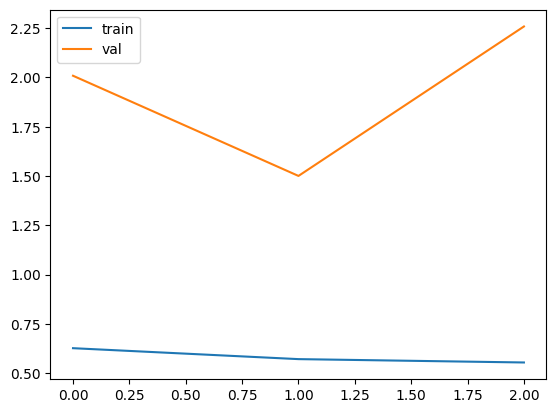

In [ ]:
# combine the individual batched outputs and argmax for the predictions

# concatenate all the actual labels
labels_array_base = np.concatenate(all_labels_base, axis=0)

# vertically stack the predicted labels (logits) into 2D matrix where each row has two probabilities (one for each class).
# Taking argmax will give us the max value which is the predicted class for that sample. So it will be 1D array containing predicted class labels to meet format of true labels
preds_array_base = np.argmax(np.concatenate(all_preds_base, axis=0), axis=1)

# now that the preds and labels are in a similar format, we can compare with sklearn metrics
print(accuracy_score(labels_array_base, preds_array_base))

plt.plot(history_base['train_loss'], label='train')
plt.plot(history_base['val_loss'], label='val')
plt.legend()
plt.show()

After training the model for 5 epochs, we found that the validation loss does seem to degrade after third epoch. The training loss also degrades after first epoch. So that means we really don't need to train our base model more than 2 epochs (even with conservative estimation). Our accuracy is only 35%.

# Transfer Learning

## Load up the pre-trained BERT base model

In [ ]:
import zipfile

In [ ]:
# Load the model

# Path to the .zip file
zip_file_path = '/content/bert_model_base.zip'

# Directory where the model will be extracted (need to make sure that all the necesary files of saved model are NOT be in nested folder)
extract_path = '/content/bert_model_base/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Specify the path where the model is extracted
model_base_path = '/content/bert_model_base/'

# Load the model
model_new = BertForSequenceClassification.from_pretrained(model_base_path)

In [ ]:
model_new

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# place the new model to GPU
model_new.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Add custom layers to the model

Now we will unfreeze last two BERT layers, pooling layer, and classifier layer. Then we will add custom layers on top of that model.

In [ ]:
# Freeze the entire model initially
for param in model_new.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers of BERT
for layer in model_new.bert.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Also unfreeze the pooler (final layer before classifier)
for param in model_new.bert.pooler.parameters():
    param.requires_grad = True

# Unfreeze the classifier layer, as we want to modify or retrain it for our new task
for param in model_new.classifier.parameters():
    param.requires_grad = True

# Add custom layers to the model
model_new.dropout = nn.Dropout(0.5).to(device)  # Dropout layer
model_new.dense = nn.Linear(model_new.config.hidden_size, model_new.config.hidden_size).to(device)   # Reduce to 256 to control model complexity
model_new.relu = nn.ReLU().to(device)  # ReLU activation
model_new.classifier = nn.Linear(model_new.config.hidden_size, 3).to(device)   # Final classification layer for 3 classes

# Similar to before collect trainable parameters: last 2 BERT layers, pooler layer, classifier, and custom layers
train_params_new = (
    list(model_new.bert.encoder.layer[-2:].parameters()) +  # Last 2 BERT layers
    list(model_new.bert.pooler.parameters()) +  # Pooler layer
    list(model_new.dropout.parameters()) +  # Dropout layer
    list(model_new.dense.parameters()) +  # Custom dense layer
    list(model_new.relu.parameters()) +  # ReLU (if needed, but it's usually stateless)
    list(model_new.classifier.parameters())  # Final classifier layer
)

# we can now tell the optimizer to only optimize these parameters in the model
optimizer_new = Adam(train_params_new)

In [ ]:
model_new

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Okay our custom layers have been added and our new custom model is ready.

## Train the new model

Let's train our new model and evaluate its performance. We will do them separately.

In [ ]:
# Setup tracking for this new custom model
history_new = {'val_loss': [], 'train_loss': []}
epochs = 3  # Number of training epochs

# Training Loop
history_new['train_loss'] = []  # Reset training loss history

with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new.train()  # Set model to training mode
        total_loss = 0.0

        for batch in tqdm(train_dataloader, desc=f"Training {epoch}", total=int(train_size/Batch_size)+1, leave=False):

            # Send batch to GPU and unpack input parameters & labels
            batch = tuple(s.to(device) for s in batch)
            input_ids, input_mask, input_types, labels = batch

            # Forward pass
            output = model_new(input_ids=input_ids, attention_mask=input_mask, labels=labels, output_hidden_states=True)
            hidden_states = output.hidden_states[-1][:, 0, :]  # Get CLS token representation

            # Move logits to the same device(GPU/CPU) as model
            logits = output.logits.to(device)

            # Apply custom layers
            logits = model_new.dropout(hidden_states)
            logits = model_new.dense(logits)
            logits = model_new.relu(logits)
            logits = model_new.classifier(logits)

            # Compute loss
            loss = nn.CrossEntropyLoss()(logits, labels)

            # Backpropagation
            loss.backward()
            optimizer_new.step()
            optimizer_new.zero_grad()

            total_loss += loss.item() * len(batch)

        # Calculate avg. training loss and store in history
        avg_loss = total_loss / len(train_dataloader.dataset)
        history_new['train_loss'].append(avg_loss)
        pbar.set_postfix(train_loss=f"{avg_loss:.4f}")
        print(f"Training Loss: {avg_loss:.4f}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training 0:   0%|          | 0/867 [00:00<?, ?it/s]

Training 1:   0%|          | 0/867 [00:00<?, ?it/s]

Training 2:   0%|          | 0/867 [00:00<?, ?it/s]

In [ ]:
print(history_new['train_loss'])  # Check the training loss for each epoch

[0.16216751981277114, 0.15483218704201884, 0.1450016364115387]


The training loss decreases after each epoch although it's not that signficant improvement.

## Evaluation of new model

In [ ]:
# Evaluation Loop
history_new['val_loss'] = []  # Reset validation loss history
model_new.eval()  # Set model to evaluation mode
total_loss = 0.0  # reset the loss to track validation loss

for epoch in pbar:

  # turn off gradient calculations for evaluation
  with torch.no_grad():

    for batch in tqdm(eval_dataloader, desc=f"Evaluating {epoch}", total=int(eval_size/Batch_size)+1, leave=False):
        batch = tuple(s.to(device) for s in batch)
        input_ids, input_mask, input_types, labels = batch

        # Forward pass
        output = model_new(input_ids=input_ids, attention_mask=input_mask, labels=labels, output_hidden_states=True)
        hidden_states = output.hidden_states[-1][:, 0, :]  # Get CLS token representation

        # Apply custom layers
        logits = model_new.dropout(hidden_states)
        logits = model_new.dense(logits)
        logits = model_new.relu(logits)
        logits = model_new.classifier(logits)

        # Compute loss
        loss = nn.CrossEntropyLoss()(logits, labels)
        total_loss += loss.item() * Batch_size

    avg_loss = total_loss / eval_size
    history_new['val_loss'].append(avg_loss)
    pbar.set_postfix(val_loss=f"{avg_loss:.4f}")
    print(f"Validation Loss: {avg_loss:.4f}")

Evaluating 0:   0%|          | 0/217 [00:00<?, ?it/s]

Validation Loss: 0.5524


Evaluating 1:   0%|          | 0/217 [00:00<?, ?it/s]

Validation Loss: 1.1048


Evaluating 2:   0%|          | 0/217 [00:00<?, ?it/s]

Validation Loss: 1.6571


As we can see that the validation loss degrades after the first epoch, the model is not able to generalize well to unseen data. Model's performance is getting worse after first epoch.

## New model's predictions and accuracy

In [ ]:
all_preds_new = []   # stores predicted labels for each batch
all_labels_new = []  # stores true labels for each batch

model_new.eval() # set model to evalaution mode (no dropout, etc.)

# run the evaluation without tracking gradient operations (same as before)
with torch.no_grad():
    for batch in tqdm(eval_dataloader,desc="Evaluating", total=int(eval_size/Batch_size)+1):

        batch = tuple(s.to(device) for s in batch) # send to GPU
        input_ids, input_mask, input_types, labels = batch

        output = model_new(input_ids, input_types, input_mask, labels=None)

        # remove the raw unnormalized predictions tensors "outpu.logits" from computation graph and move them to CPU from GPU
        # convert the tensors into numpy array for later use (easier this way)
        all_preds_new.append(  output.logits.detach().cpu().numpy() )
        all_labels_new.append( labels.cpu().numpy() )  # move labels to CPU and convert them to numpy arrays

Evaluating:   0%|          | 0/217 [00:00<?, ?it/s]

0.35613275613275613


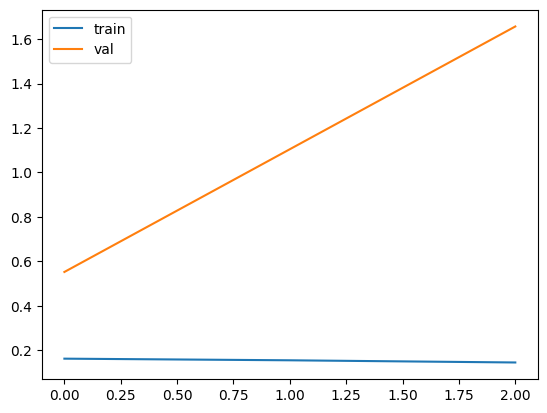

In [ ]:
# combine the individual batched outputs and argmax for the predictions

# concatenate all the actual labels
labels_array_new = np.concatenate(all_labels_new, axis=0)

# vertically stack the predicted labels (logits) into 2D matrix where each row has two probabilities (one for each class).
# Taking argmax will give us the max value which is the predicted class for that sample. So it will be 1D array containing predicted class labels to meet format of true labels
preds_array_new = np.argmax(np.concatenate(all_preds_new, axis=0), axis=1)

# now that the preds and labels are in a similar format, we can compare with sklearn metrics
print(accuracy_score(labels_array_new, preds_array_new))

plt.plot(history_new['train_loss'], label='train')
plt.plot(history_new['val_loss'], label='val')
plt.legend()
plt.show()

As stated before, the model performance degrades after first epoch. It's best accuracy is only 35%.

## Use cross validation for splitting the data

### Train and Eval datasets setup

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# Initialize KFold for cross-validation
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Setup tracking for this new custom model using cross validation
history_new_cv = {'val_loss_cv': [], 'train_loss_cv': []}
epochs = 3  # Number of training epochs

# Cross-validation loop
for fold, (train_idx, eval_idx) in enumerate(cv.split(all_data_tensors)):

    print(f"Training fold {fold + 1}/{n_splits}...")

    # Reinitialize model for each fold
    model_new.to(device)  # Move model to GPU/CPU

    # Create train and evaluation datasets for this fold
    train_data_cv = torch.utils.data.Subset(all_data_tensors, train_idx)
    eval_data_cv = torch.utils.data.Subset(all_data_tensors, eval_idx)

    # Create data loaders for train and eval sets
    train_sampler_cv = RandomSampler(train_data_cv)
    train_dataloader_cv = DataLoader(train_data_cv, sampler=train_sampler_cv, batch_size=Batch_size)

    eval_sampler_cv = SequentialSampler(eval_data_cv)
    eval_dataloader_cv = DataLoader(eval_data_cv, sampler=eval_sampler_cv, batch_size=Batch_size)

    # Reset history for this fold
    history_new_cv['train_loss_cv'] = []

    # Training Loop
    with trange(epochs, desc="Epoch") as pbar:
        for epoch in pbar:
            model_new.train()  # Set model to training mode
            total_loss_cv = 0.0

            # Iterate over training batches
            for batch in tqdm(train_dataloader_cv, desc=f"Training {epoch}", total=int(train_size/Batch_size)+1, leave=False):
                batch = tuple(s.to(device) for s in batch)  # Send batch to GPU
                input_ids, input_mask, input_types, labels = batch

                # Forward pass
                output = model_new(input_ids=input_ids, attention_mask=input_mask, labels=labels, output_hidden_states=True)
                hidden_states = output.hidden_states[-1][:, 0, :]  # Get CLS token representation

                # Apply custom layers
                logits = model_new.dropout(hidden_states)
                logits = model_new.dense(logits)
                logits = model_new.relu(logits)
                logits = model_new.classifier(logits)

                # Compute loss
                loss_cv = nn.CrossEntropyLoss()(logits, labels)

                # Backpropagation
                loss_cv.backward()
                optimizer_new.step()
                optimizer_new.zero_grad()

                total_loss_cv += loss_cv.item() * len(batch)

            # Calculate average training loss for the fold
            avg_loss_cv = total_loss_cv / len(train_dataloader_cv.dataset)
            history_new_cv['train_loss_cv'].append(avg_loss_cv)
            pbar.set_postfix(train_loss_cv=f"{avg_loss_cv:.4f}")
            print(f"Training Loss after fold {fold + 1}: {avg_loss_cv:.4f}")

    # Optional: Perform evaluation after training for this fold
    # Evaluation loop (if needed, similar to your evaluation code)
    # Store the evaluation loss for cross-validation tracking in history_new_cv['val_loss_cv']
    # eval_dataloader and other code to evaluate the model on the validation set for this fold


In [ ]:
total_reviews = 17321   # Total number of reviews
n_splits = 3            # Number of cross-validation folds (3-fold cross-validation)

# Initialize KFold for cross-validation
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each fold. We will use "all_data_tensors" from base_model section
for fold, (train_idx, eval_idx) in enumerate(cv.split(all_data_tensors)):

    print(f"Training fold {fold + 1}/{n_splits}...")

    # Create train and evaluation datasets for this fold
    train_data_cv = torch.utils.data.Subset(all_data_tensors, train_idx)
    eval_data_cv = torch.utils.data.Subset(all_data_tensors, eval_idx)

    # Create data loaders for train and eval sets
    train_sampler_cv = RandomSampler(train_data_cv)
    train_dataloader_cv = DataLoader(train_data_cv, sampler=train_sampler_cv, batch_size=Batch_size)

    eval_sampler_cv = SequentialSampler(eval_data_cv)
    eval_dataloader_cv = DataLoader(eval_data_cv, sampler=eval_sampler_cv, batch_size=Batch_size)

    print(f"Fold {fold + 1} complete.")


Training fold 1/3...
Fold 1 complete.
Training fold 2/3...
Fold 2 complete.
Training fold 3/3...
Fold 3 complete.


### Train the new model

In [ ]:
# Setup tracking for this new custom model
history_new_cv = {'val_loss_cv': [], 'train_loss_cv': []}
epochs = 3  # Number of training epochs

# Training Loop
history_new_cv['train_loss_cv'] = []  # Reset training loss history

with trange(epochs, desc="Epoch") as pbar:

    for epoch in pbar:
        model_new.train()  # Set model to training mode
        total_loss = 0.0

        for batch in tqdm(train_dataloader_cv, desc=f"Training {epoch}", total=int(train_size/Batch_size)+1, leave=False):

            # Send batch to GPU and unpack input parameters & labels
            batch = tuple(s.to(device) for s in batch)
            input_ids, input_mask, input_types, labels = batch

            # Forward pass
            output = model_new(input_ids=input_ids, attention_mask=input_mask, labels=labels, output_hidden_states=True)
            hidden_states = output.hidden_states[-1][:, 0, :]  # Get CLS token representation

            # Move logits to the same device(GPU/CPU) as model
            logits = output.logits.to(device)

            # Apply custom layers
            logits = model_new.dropout(hidden_states)
            logits = model_new.dense(logits)
            logits = model_new.relu(logits)
            logits = model_new.classifier(logits)

            # Compute loss
            loss_cv = nn.CrossEntropyLoss()(logits, labels)

            # Backpropagation
            loss_cv.backward()
            optimizer_new.step()
            optimizer_new.zero_grad()

            total_loss += loss_cv.item() * len(batch)

        # Calculate avg. training loss and store in history
        avg_loss_cv = total_loss / len(train_dataloader_cv.dataset)
        history_new_cv['train_loss_cv'].append(avg_loss_cv)
        pbar.set_postfix(train_loss_cv=f"{avg_loss_cv:.4f}")
        print(f"Training Loss after cross validation: {avg_loss_cv:.4f}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training 0:   0%|          | 0/867 [00:00<?, ?it/s]

Training Loss after cross validation: 0.1357


Training 1:   0%|          | 0/867 [00:00<?, ?it/s]

Training Loss after cross validation: 0.1284


Training 2:   0%|          | 0/867 [00:00<?, ?it/s]

Training Loss after cross validation: 0.1275


Compared to previous model where we used random split of the dataset, we can see that the training loss started with a better loss as it started with 0.1357 compared to 0.1621. But as before, the loss does not improve much after first epoch.

### Evaluating new model

In [ ]:
# Evaluation Loop
history_new_cv['val_loss_cv'] = []  # Reset validation loss history
model_new.eval()  # Set model to evaluation mode
total_loss = 0.0  # reset the loss to track validation loss

for epoch in pbar:

  # turn off gradient calculations for evaluation
  with torch.no_grad():

    for batch in tqdm(eval_dataloader_cv, desc=f"Evaluating {epoch}", total=int(eval_size/Batch_size)+1, leave=False):
        batch = tuple(s.to(device) for s in batch)
        input_ids, input_mask, input_types, labels = batch

        # Forward pass
        output = model_new(input_ids=input_ids, attention_mask=input_mask, labels=labels, output_hidden_states=True)
        hidden_states = output.hidden_states[-1][:, 0, :]  # Get CLS token representation

        # Apply custom layers
        logits = model_new.dropout(hidden_states)
        logits = model_new.dense(logits)
        logits = model_new.relu(logits)
        logits = model_new.classifier(logits)

        # Compute loss
        loss_cv = nn.CrossEntropyLoss()(logits, labels)
        total_loss += loss_cv.item() * Batch_size

    avg_loss_cv = total_loss / eval_size
    history_new_cv['val_loss_cv'].append(avg_loss_cv)
    pbar.set_postfix(val_loss_cv=f"{avg_loss_cv:.4f}")
    print(f"Validation Loss after cross validation: {avg_loss_cv:.4f}")

Evaluating 0:   0%|          | 0/217 [00:00<?, ?it/s]

Validation Loss after cross validation: 0.8646


Evaluating 1:   0%|          | 0/217 [00:00<?, ?it/s]

Validation Loss after cross validation: 1.7293


Evaluating 2:   0%|          | 0/217 [00:00<?, ?it/s]

In [ ]:
all_preds_new_cv = []   # stores predicted labels for each batch
all_labels_new_cv = []  # stores true labels for each batch

model_new.eval() # set model to evalaution mode (no dropout, etc.)

# run the evaluation without tracking gradient operations (same as before)
with torch.no_grad():
    for batch in tqdm(eval_dataloader_cv,desc="Evaluating", total=int(eval_size/Batch_size)+1):

        batch = tuple(s.to(device) for s in batch) # send to GPU
        input_ids, input_mask, input_types, labels = batch

        output = model_new(input_ids, input_types, input_mask, labels=None)

        # remove the raw unnormalized predictions tensors "outpu.logits" from computation graph and move them to CPU from GPU
        # convert the tensors into numpy array for later use (easier this way)
        all_preds_new_cv.append(  output.logits.detach().cpu().numpy() )
        all_labels_new_cv.append( labels.cpu().numpy() )  # move labels to CPU and convert them to numpy arrays

In [ ]:
# combine the individual batched outputs and argmax for the predictions

# concatenate all the actual labels
labels_array_new_cv = np.concatenate(all_labels_new_cv, axis=0)

# vertically stack the predicted labels (logits) into 2D matrix where each row has two probabilities (one for each class).
# Taking argmax will give us the max value which is the predicted class for that sample. So it will be 1D array containing predicted class labels to meet format of true labels
preds_array_new_cv = np.argmax(np.concatenate(all_preds_new_cv, axis=0), axis=1)

# now that the preds and labels are in a similar format, we can compare with sklearn metrics
print(accuracy_score(labels_array_new_cv, preds_array_new_cv))

plt.plot(history_new_cv['train_loss_cv'], label='train_cv')
plt.plot(history_new_cv['val_loss_cv'], label='val_cv')
plt.legend()
plt.show()